In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import expon
from scipy.optimize import minimize
from mpl_toolkits import mplot3d
%matplotlib inline

In [119]:
def Z(mu, sigma):
    return(norm.cdf(mu/sigma))

def g(x, mu, sigma):
    return((x > 0)*norm.pdf(x, mu, sigma)/(Z(mu, sigma)))

def M1(mu, sigma):
    return(1/Z(mu, sigma))

def Lambda_Star(mu, sigma):
    Delta = mu*mu+4*sigma*sigma
    return((-mu+np.sqrt(Delta))/(2*sigma*sigma))

def M2(mu, sigma):
    L_Star = Lambda_Star(mu, sigma)
    return((np.exp(mu*L_Star+sigma*sigma*L_Star*L_Star/2))/(L_Star*Z(mu, sigma)*np.sqrt(2*np.pi)*sigma))

def AR_Norm_Simple(mu, sigma):
    X = -1
    M_1 = M1(mu, sigma)
    M_2 = M2(mu, sigma)
    if(M_2 >= M_1):
        while(X == -1):
            Y = mu+sigma*norm.rvs()
            if(Y > 0):
                X = Y
    else:
        while(X == -1):
            L_Star = Lambda_Star(mu, sigma)
            Y = expon.rvs(scale = 1/L_Star)
            U = uniform.rvs()
            if(g(Y, mu, sigma)/(M_2*expon.pdf(Y, scale = 1/L_Star)) >= U):
                X = Y
    return(X) 

def params(i, mu, Q, X):
    mu_x = mu[i]-np.sum([Q[i,j]*(X[j]-mu[j]) for j in range(len(mu)) if j != i])/Q[i,i]
    sigma_squared_x = 1/Q[i,i]
    return(mu_x, sigma_squared_x)

def Gibbs_Sampler(n, mu, Sigma, X0):
    d = len(mu)
    Q = np.linalg.inv(Sigma)
    X = [list(X0)]
    for _n in range(n-1):
        for i in range(d):
            mu_x, s_s_x = params(i, mu, Q, X0)
            X0[i] = AR_Norm_Simple(mu_x, np.sqrt(s_s_x))
        X.append(list(X0))
    return(np.array(X)[int(0.05*n):,:])

def plot_Gibbs_2D(X, mu, Sigma):
    d = len(mu)
    Q = np.linalg.inv(Sigma)
    fig, axs = plt.subplots(d, figsize = (10,15))
    for t in range(d):
        x = np.linspace(0, mu[t]+4*Sigma[t,t], 10000)
        y = np.array([dense_1(xx, t, mu, Sigma, Q) for xx in x])
        axs[t].hist(X[:,t], density = True, bins = 40, label = "Histogramme des simulations")
        axs[t].plot(x, y, label = "Densité théorique")
    fig.suptitle('Densités théoriques et pratiques', y = 0.9)
    
def autocorr(X, t):
    X_t = np.transpose(X)
    if(t == 0):
        return(np.corrcoef(X_t[:,:],X_t[:,:]))
    return(np.corrcoef(X_t[:,t:],X_t[:,:-t]))

def graph_autocorr(X, t = 50):
    Lags = [_n for _n in range(t+1)]
    d = X.shape[1]
    fig, axs = plt.subplots(d, figsize = (10,15))
    for _d in range(d):
        Auto = [autocorr(X, lag)[_d,_d+3] for lag in Lags]
        axs[_d].plot([-int(t/50),t+int(t/50)],[0,0], color = 'black')
        axs[_d].plot([-int(t/50),t+int(t/50)],[0.2,0.2], color = 'blue', linestyle='dashed')
        axs[_d].plot([-int(t/50),t+int(t/50)],[-0.2,-0.2], color = 'blue', linestyle='dashed')
        for i in range(len(Auto)):
            axs[_d].plot([Lags[i], Lags[i]], [0, Auto[i]], color = 'black')
        axs[_d].axis([-int(t/50),t+int(t/50),min(Auto)-0.1,max(Auto)+0.1])
    fig.suptitle('Graphes des autocorrélations', y = 0.9)

In [132]:
n = 5_000
d = 3
mu = np.array([3,0,1])
Sigma = np.array([[2.0,2.5,1.0],
                  [2.5,4.0,1.0],
                  [1.0,1.0,1.0]])
Q = np.linalg.inv(Sigma)

X0 = expon.rvs(size = 3)

X = Gibbs_Sampler(n, mu, Sigma, X0)

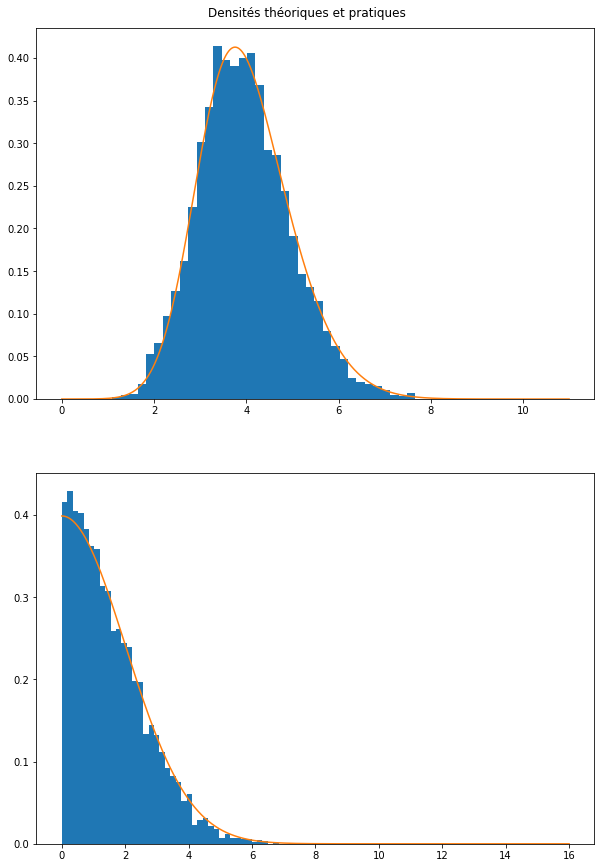

In [120]:
#plot_Gibbs_2D(X, mu, Sigma)

In [111]:
def Z(mu, sigma):
    return(norm.cdf(mu/sigma))

def g(x, mu, sigma):
    return((x >= 0)*norm.pdf(x, mu, sigma)/(Z(mu, sigma)))

def params(i, mu, Q, X):
    mu_x = mu[i]-np.sum([Q[i,j]*(X[j]-mu[j]) for j in range(len(mu)) if j != i])/Q[i,i]
    sigma_squared_x = 1/Q[i,i]
    return(mu_x, sigma_squared_x)

def dense_1(y, i, mu, Sigma, Q):
    Z_cst = (1 - norm.cdf(0,loc=mu[0],scale=np.sqrt(Sigma[0,0]))
               - norm.cdf(0,loc=mu[1],scale=np.sqrt(Sigma[1,1]))
               + multivariate_normal.cdf(np.zeros(2),mean=mu,cov=Sigma))
    X = np.ones(len(mu))
    j = 0 if i == 1 else 1
    X[i] = y
    p = params(j, mu, Q, X)
    d1 = (0 <= X).all()*(multivariate_normal.pdf(X, mean = mu, cov = Sigma))/(Z_cst)
    d2 = g(1, p[0], np.sqrt(p[1]))
    return(d1/d2)

In [133]:
N = 10_000

mu_prime = np.array([3.2,-0.2,0.1])
Sigma_prime = np.array([[2.5,0.8,1.0],
                        [0.8,4.5,0.0],
                        [1.0,0.0,2.0]])
Q_prime = np.linalg.inv(Sigma_prime)

Y0 = expon.rvs(size = 3)

Y = Gibbs_Sampler(N, mu_prime, Sigma_prime, Y0)

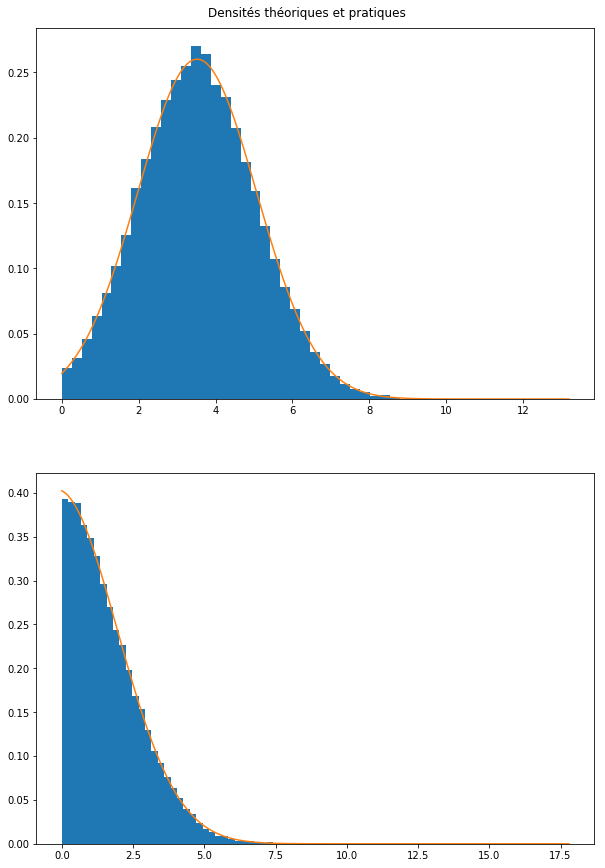

In [122]:
#plot_Gibbs_2D(Y, mu_prime, Sigma_prime)

$l(x; \mu; \Sigma) = \log(\dfrac{1}
{Z(\boldsymbol{\mu}, \boldsymbol{\Sigma})(2\pi)^{N/2} \left| \boldsymbol{\Sigma}\right|^{1/2}}\exp\left[
-\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)\right] \, \mathbb{1}_{x > 0})$

$l(x; \mu; \Sigma) = -\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right) - \log(Z(\boldsymbol{\mu}, \boldsymbol{\Sigma}))-\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma}\right|) + Cst$

$l(x; \mu; \Sigma) = -\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right) - \log(\dfrac{Z(\boldsymbol{\mu}, \boldsymbol{\Sigma})}{Z(\boldsymbol{\mu'}, \boldsymbol{\Sigma'})}Z(\boldsymbol{\mu'}, \boldsymbol{\Sigma'}))-\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma}\right|) + Cst$

or $\dfrac{Z(\boldsymbol{\mu}, \boldsymbol{\Sigma})}{Z(\boldsymbol{\mu'}, \boldsymbol{\Sigma'})} = \dfrac{1}{Z(\boldsymbol{\mu'}, \boldsymbol{\Sigma'})}\int_{}^{} \dfrac{1}
{(2\pi)^{N/2} \left| \boldsymbol{\Sigma}\right|^{1/2}}\;\exp\left[
-\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)\right] \, \mathbb{1}_{x > 0}\mathrm{d}x = \dfrac{1}{Z(\boldsymbol{\mu'}, \boldsymbol{\Sigma'})}\int_{}^{} 
f(x; \boldsymbol{\mu}, \boldsymbol{\Sigma}) \mathbb{1}_{x > 0}\mathrm{d}x$

$ = \dfrac{1}{Z(\boldsymbol{\mu'}, \boldsymbol{\Sigma'})}\int_{}^{} 
\dfrac{f(x; \boldsymbol{\mu}, \boldsymbol{\Sigma})}{f(x; \boldsymbol{\mu'}, \boldsymbol{\Sigma'})}f(x; \boldsymbol{\mu'}, \boldsymbol{\Sigma'}) \mathbb{1}_{x > 0}\mathrm{d}x = \mathbb{E}\left[\dfrac{f(Y; \boldsymbol{\mu}, \boldsymbol{\Sigma})}{f(Y; \boldsymbol{\mu'}, \boldsymbol{\Sigma'})}\right]$ où $Y \sim \mathcal{N}_{tr}(\mu', \Sigma')$ où $\mu'$ et $\Sigma'$ ne dépendent pas directement de $\mu$ et $\Sigma$ et sont donc constants d'où:

$l(x; \mu; \Sigma) = -\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right) - \log(\mathbb{E}\left[\dfrac{f(Y; \boldsymbol{\mu}, \boldsymbol{\Sigma})}{f(Y; \boldsymbol{\mu'}, \boldsymbol{\Sigma'})}\right])-\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma}\right|) + Cst $

$ = -\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right) - \log(\dfrac{\left| \boldsymbol{\Sigma'}\right|^{1/2}}{\left| \boldsymbol{\Sigma}\right|^{1/2}}\mathbb{E}\left[\exp\left[\dfrac{\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)}{2}\right]\right])-\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma}\right|) + Cst $

$ = -\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right) - \log(\mathbb{E}\left[\exp\left[\dfrac{\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)}{2}\right]\right])-\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma}\right|)+\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma}\right|)-\dfrac{1}{2}\log(\left| \boldsymbol{\Sigma'}\right|) + Cst = -\dfrac{1}{2}\left(\boldsymbol{x}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{x}-\boldsymbol{\mu}\right) - \log(\mathbb{E}\left[\exp\left[\dfrac{\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)}{2}\right]\right]) + Cst$

On approximera ensuite $\mathbb{E}\left[\exp\left[\dfrac{\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y}-\boldsymbol{\mu}\right)}{2}\right]\right]$ par: $\dfrac{1}{m}\displaystyle \sum_{i = 1}^{m} \exp\left[\dfrac{\left(\boldsymbol{Y_i}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y_i}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y_i}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y_i}-\boldsymbol{\mu}\right)}{2}\right]$

Finalement on cherche à minimiser:

$L(\mu, \Sigma) = \displaystyle \sum_{i = 1}^{n} \dfrac{1}{2}\left(\boldsymbol{X_i}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{X_i}-\boldsymbol{\mu}\right) + \log(\displaystyle \sum_{j = 1}^{m} \exp\left[\dfrac{\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)}{2}\right])$, on a, en particulier, les dérivées suivantes:

$\dfrac{\partial L}{\partial \mu}(\mu, \Sigma) = \displaystyle \sum_{i = 1}^{n} - \left(\boldsymbol{X_i}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1} + \dfrac{\displaystyle \sum_{j = 1}^{m} \left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\exp\left[\dfrac{\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)}{2}\right]}{\displaystyle \sum_{j = 1}^{m} \exp\left[\dfrac{\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)}{2}\right]}$

$\dfrac{\partial L}{\partial \sigma_{ij}}(\mu, \Sigma) = \displaystyle \sum_{i = 1}^{n} -\dfrac{1}{2}\left(\boldsymbol{X_i}-\boldsymbol{\mu}\right)^\top C(\boldsymbol{\Sigma})\left(\boldsymbol{X_i}-\boldsymbol{\mu}\right) + \dfrac{\displaystyle \sum_{j = 1}^{m} \dfrac{1}{2}\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top C(\boldsymbol{\Sigma})\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)\exp\left[\dfrac{\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)}{2}\right]}{\displaystyle \sum_{j = 1}^{m} \exp\left[\dfrac{\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)^\top\boldsymbol{\Sigma'}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu'}\right)-\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)^\top\boldsymbol{\Sigma}^{-1}\left(\boldsymbol{Y_j}-\boldsymbol{\mu}\right)}{2}\right]}$ 

où $C(\boldsymbol{\Sigma}) =  \boldsymbol{\Sigma}^{-1}\dfrac{\partial \boldsymbol{\Sigma}}{\partial \sigma_{ij}}\boldsymbol{\Sigma}^{-1}$.

In [134]:
def OP(Y, mu, Sigma_inv):
    return(np.dot(np.dot(Y-mu, Sigma_inv), np.transpose(Y-mu))/2)

Stock = np.array([OP(Yi, mu_prime, Q_prime) for Yi in Y])

In [124]:
def Transform(P, d):
    M = np.zeros((d, d))
    for i in range(d):
        M[i, :i+1] = P[int(i*(i+1)/2): int(i*(i+1)/2)+i+1]
        M[i, i] = M[i, i]**2
    return(M)

def Transform_inv(M):
    d = M.shape[0]
    P = list(np.concatenate([M[i, :i+1] for i in range(M.shape[0])]))
    for i in range(d):
        P[int(i*(i+1)/2)+i] = P[int(i*(i+1)/2)+i]**0.5
    return(P)

In [125]:
def l(P, X, Y, Stock):
    mu = P[:d]
    K = Transform(P[d:], d)
    Sigma = np.dot(K, K.T)
    Q = np.linalg.inv(Sigma)
    return(np.sum(np.dot(X-mu, Q)*(X-mu))/2+X.shape[0]*np.log(np.sum(np.exp(Stock-np.sum(np.dot(Y-mu, Q)*(Y-mu), axis = 1)/2))))

In [126]:
def dSigma_ij(Sigma, Q, i, j):
    d = Sigma.shape[0]
    dSigma = np.zeros((d,d))
    dSigma[i, j] = 1
    return(np.dot(np.dot(Q, dSigma),Q))

def dl_ij(mu, Sigma, Q, Stock_expY, i, j):
    dS_ij = dSigma_ij(Sigma, Q, i, j)
    Stock_X = np.array([-OP(Xi, mu, dS_ij) for Xi in X])
    Stock_Y = np.array([OP(Yi, mu, dS_ij) for Yi in Y])
    Somme = np.sum(Stock_X+np.sum(Stock_Y*np.exp(Stock_expY))/np.sum(np.exp(Stock_expY)))
    return(Somme)

def dl_mu(mu, Sigma, Q, Stock_expY):
    Stock_X = np.array([-np.dot(Xi-mu, Q) for Xi in X])
    Stock_Y = np.array([np.dot(Yi-mu, Q) for Yi in Y])
    Stock_Y_T = np.array([Stock_Y[i]*np.exp(Stock_expY[i]) for i in range(len(Stock_Y))])
    Somme = np.sum(Stock_X, axis = 0)+len(Stock_X)*np.sum(Stock_Y_T, axis = 0)/np.sum(np.exp(Stock_expY))
    return(Somme)

def Jacob_l(P):
    mu = P[:d]
    Sigma = P[d:].reshape(d, d)
    Q = np.linalg.inv(Sigma)
    Stock_expY = Stock+np.array([-OP(Yi, mu, Q) for Yi in Y])
    result = np.concatenate((dl_mu(mu, Sigma, Q, Stock_expY), [dl_ij(mu, Sigma, Q, Stock_expY, i, j) for j in range(d) for i in range(d)]))
    return(result)

In [138]:
mu_0 = np.array([2,-1,0])
Sigma_0 = np.array([[2,1,1],
                    [1,3,1],
                    [1,1,2]])
K_0 = np.linalg.cholesky(Sigma_0)

In [142]:
print('Le moyenne initialisante est:')
print(mu_0)
print('La matrice de covariance initialisante est:')
print(Sigma_0)
print('Le moyenne de Y est:')
print(mu_prime)
print('La matrice de covariance de Y est:')
print(Sigma_prime)

Le moyenne initialisante est:
[ 2 -1  0]
La matrice de covariance initialisante est:
[[2 1 1]
 [1 3 1]
 [1 1 2]]
Le moyenne de Y est:
[ 3.2 -0.2  0.1]
La matrice de covariance de Y est:
[[2.5 0.8 1. ]
 [0.8 4.5 0. ]
 [1.  0.  2. ]]


In [144]:
P0 = np.concatenate((mu_0, Transform_inv(K_0)))
start = time.time()
res = minimize(l, P0, method = 'BFGS', args = (X, Y, Stock))
end = time.time()
K_find = Transform(res.x[d:], d)
print('Le vecteur des vrais moyennes est:')
print(mu)
print('Son estimateur est:')
print(res.x[:d])
print('La vrai matrice de covariance est:')
print(np.dot(K_find, K_find.T))
print('Son estimateur est:')
print(Sigma)
print('Norme de la différence des moyennes:')
print(np.sqrt(np.mean(np.abs(mu-res.x[:d]))))
print('Norme de la différence des matrices de covariance:')
print(np.sqrt(np.mean(np.abs(Sigma-np.dot(K_find, K_find.T)))))
print("durée = ", end-start, " sec")

Le vecteur des vrais moyennes est:
[3 0 1]
Son estimateur est:
[ 2.83150221 -0.26911548  0.98692885]
La vrai matrice de covariance est:
[[2.33959026 2.99745677 1.07316867]
 [2.99745677 4.73145524 1.09896622]
 [1.07316867 1.09896622 1.02111333]]
Son estimateur est:
[[2.  2.5 1. ]
 [2.5 4.  1. ]
 [1.  1.  1. ]]
Norme de la différence des moyennes:
0.3875927460962562
Norme de la différence des matrices de covariance:
0.5197587194529224
durée =  0.7199218273162842  sec


In [131]:
res

      fun: 51991.14931005725
 hess_inv: array([[ 7.08572258e-04,  9.25109833e-04, -1.52248437e-04,
        -5.39950039e-04, -5.40609663e-06],
       [ 9.25109833e-04,  1.84862295e-03, -1.36192815e-04,
        -8.71673885e-04, -1.21150039e-04],
       [-1.52248437e-04, -1.36192815e-04,  6.85677491e-05,
         1.75305106e-04, -1.04609136e-05],
       [-5.39950039e-04, -8.71673885e-04,  1.75305106e-04,
         8.00124988e-04,  2.73373968e-05],
       [-5.40609663e-06, -1.21150039e-04, -1.04609136e-05,
         2.73373968e-05,  4.18994413e-05]])
      jac: array([ 0.00048828, -0.00048828, -0.00048828,  0.        , -0.00146484])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 309
      nit: 29
     njev: 44
   status: 2
  success: False
        x: array([ 2.92000027, -0.13456979,  1.19194603,  1.76074353,  0.97712592])